I will use the following notebook to demonstrate different steps in preprocessing
These steps will include:
1) Slice timing correction
2) Motion correction
3) Coregistration


In [25]:
import os
from glob import glob
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"

%matplotlib inline

sid = ['001']
base_dir = '/Users/alisha/Desktop/CogNeuro-Imaging-Methods/Mattfeld_PSB6351'
work_dir = '/Users/alisha/Desktop/CogNeuro-Imaging-Methods/'  
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-01/func')
fmap_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-01/fmap')
fsl_dir = os.path.join(base_dir, 'derivatives', 'fsl')
anat_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-01/anat')

func_json = sorted(glob(func_dir + '/*.json'))
func_files = sorted(glob(func_dir + '/*.nii.gz'))
fmap_files = sorted(glob(fmap_dir + '/*func*.nii.gz'))
anat_files = sorted(glob(anat_dir + '/*T1w*.nii.gz'))

func_files[0]
anat_files[1]

'/Users/alisha/Desktop/CogNeuro-Imaging-Methods/Mattfeld_PSB6351/dset/sub-001/ses-01/anat/sub-001_ses-01_run-02_T1w.nii.gz'

Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.


In [26]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

# HW3 - change the search window. how does this impact your results?
#I'm not sure how to change the search window but if I narrow the search window
#it might make it more focused but might miss important information outside the search window
#widening the search window provides a wider scope but risks include more artifacts

def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
####################################
# HW3 - what column do you query to extract the appropriate information?
#Command F in .json file for 'Slice' 
####################################
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata["SliceTiming"])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
# HW3 - what happens if you chose a different func_file?  How does it impact results
# Choosing a different func file would give you different results
# Some runs may be better due to less motion or fewer artifacts

# Is the first func file the best way to go?
# The first run might have more motion because of initial discomfort

id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
####################################
# HW3 - if you choose a different func file...should this change too?
#Each functional file may have different volumes and characteristics
# Reference volume with the fewest outliers may differ for each run
# If yes, why?  what should it change to?
extractref.inputs.in_file = func_files[0]
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.

####################################
# HW3 - what happens when you change the order of the following two nodes?
#It would apply motion correction first and then extract the volumes 
# How does that impact your results?
# Reversing might have less accurate corrections because the alignment
# would be based on a volume that has more noise leading to poorer quality 


In [27]:
# Node for motion correction
volreg = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name='volreg')
volreg.inputs.outputtype = 'NIFTI_GZ'
volreg.inputs.zpad = 4
volreg.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', volreg, 'basefile')

# Node for slice timing correction
tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file', 'slice_timing'],
                      name='tshifter')
tshifter.inputs.tr = '1.76'
tshifter.inputs.slice_timing = slice_timing_list
tshifter.inputs.outputtype = 'NIFTI_GZ'

# Connect volreg output to tshifter input
psb6351_wf.connect(volreg, 'out_file', tshifter, 'in_file')

# Skull strip so it doesn't co-register to whole head
btr = pe.Node(fsl.BET(),
                   name='bet')
btr.inputs.in_file = anat_files[1]

# Node for coregistration
filrt = pe.Node(fsl.FLIRT(),
                   #iterfield=['in_file'],
                   name='filrt')
filrt.inputs.cost = 'corratio'
filrt.inputs.dof = 6
filrt.inputs.reference = os.path.join(anat_dir, f'sub-{sid[0]}_ses-01_run-02_T1w.nii.gz')

# Connect tshifter output to flirt input
psb6351_wf.connect(extractref, 'roi_file', filrt, 'in_file')
psb6351_wf.connect(btr, 'out_file', filrt, 'reference')

# Node for smoothing using SUSAN
# Coudln't figure out how to do one node to input all the smoothing parameters
# So I made a node for each 
# Which genereated a parameter for each study file so 3X4, 6X4, etc
susan_3mm = pe.MapNode(fsl.SUSAN(),
                       iterfield=['in_file'],
                       name='smooth_3mm')
susan_3mm.inputs.brightness_threshold = 2000
susan_3mm.inputs.fwhm = 3.0
susan_3mm.inputs.output_type = 'NIFTI_GZ'

susan_6mm = pe.MapNode(fsl.SUSAN(),
                       iterfield=['in_file'],
                       name='smooth_6mm')
susan_6mm.inputs.brightness_threshold = 2000
susan_6mm.inputs.fwhm = 6.0
susan_6mm.inputs.output_type = 'NIFTI_GZ'

susan_9mm = pe.MapNode(fsl.SUSAN(),
                       iterfield=['in_file'],
                       name='smooth_9mm')
susan_9mm.inputs.brightness_threshold = 2000
susan_9mm.inputs.fwhm = 9.0
susan_9mm.inputs.output_type = 'NIFTI_GZ'

susan_12mm = pe.MapNode(fsl.SUSAN(),
                        iterfield=['in_file'],
                        name='smooth_12mm')
susan_12mm.inputs.brightness_threshold = 2000
susan_12mm.inputs.fwhm = 12.0
susan_12mm.inputs.output_type = 'NIFTI_GZ'

psb6351_wf.connect(tshifter, 'out_file', susan_3mm, 'in_file')
psb6351_wf.connect(tshifter, 'out_file', susan_6mm, 'in_file')
psb6351_wf.connect(tshifter, 'out_file', susan_9mm, 'in_file')
psb6351_wf.connect(tshifter, 'out_file', susan_12mm, 'in_file')

In [22]:
# Applying hight pass filter using fslmaths
# sigma calculation = cutoff/2*TR --> 100/2*1.76 = 28.41
# 90-120s was suggested as the cutoff for task based data 
# Picked susan_6mm because it's the best out of the 3mm-12mm range
temp_smoothing = pe.MapNode(fsl.maths.TemporalFilter(),
                          iterfield=['in_file'],
                          name='temp_smoothing')
temp_smoothing.inputs.highpass_sigma = 28.41  # Custom sigma value

# Connect 6mm smoothed data to temporal filtering
psb6351_wf.connect(susan_6mm, 'smoothed_file', temp_smoothing, 'in_file')


In [23]:
# DataSink node for saving outputs
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproc')  
datasink.inputs.container = f'sub-{sid[0]}'    

# Connect outputs to DataSink
psb6351_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')  
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref') 
psb6351_wf.connect(volreg, 'out_file', datasink, 'motion.@corrfile')  
psb6351_wf.connect(volreg, 'oned_matrix_save', datasink, 'motion.@matrix')  
psb6351_wf.connect(volreg, 'oned_file', datasink, 'motion.@par')
psb6351_wf.connect(filrt, 'out_matrix_file', datasink, 'register.@xfm_matrix')
psb6351_wf.connect(filrt, 'out_file', datasink, 'register.@xfm_file')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions') 
psb6351_wf.connect(btr, 'out_file', datasink, 'skull_strip') 
psb6351_wf.connect(susan_3mm, 'smoothed_file', datasink, 'smooth.@3mm')
psb6351_wf.connect(susan_6mm, 'smoothed_file', datasink, 'smooth.@6mm')
psb6351_wf.connect(susan_9mm, 'smoothed_file', datasink, 'smooth.@9mm')
psb6351_wf.connect(susan_12mm, 'smoothed_file', datasink, 'smooth.@12mm')
psb6351_wf.connect(temp_smoothing, 'out_file', datasink, 'filtered.@6mm')

# Run the workflow
psb6351_wf.run()

# Uncomment the following line to run the workflow on a cluster
# psb6351_wf.run(plugin='SLURM',
#                plugin_args={'sbatch_args': ('--partition IB_44C_512G --qos pq_madlab --account acc_madlab'),
#                             'overwrite': True})

241024-21:50:50,285 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
241024-21:50:50,311 nipype.workflow INFO:
	 Running serially.
241024-21:50:50,312 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.id_outliers" in "/Users/alisha/Desktop/CogNeuro-Imaging-Methods/psb6351workdir/sub-001/psb6351_wf/id_outliers".
241024-21:50:50,321 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.id_outliers" - collecting precomputed outputs
241024-21:50:50,321 nipype.workflow INFO:
	 [Node] "psb6351_wf.id_outliers" found cached.
241024-21:50:50,321 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.bet" in "/Users/alisha/Desktop/CogNeuro-Imaging-Methods/psb6351workdir/sub-001/psb6351_wf/bet".
241024-21:50:50,324 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.bet" - collecting precomputed outputs
241024-21:50:50,324 nipype.workflow INFO:
	 [Node] "psb6351_wf.bet" found cached.
241024-21:50:50,324 nipype.workflow INFO:
	 [Node] Setting-up "p

/var/folders/f3/9xmtfcls0b19f4b8lh3sws280000gn/T/ipykernel_6933/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


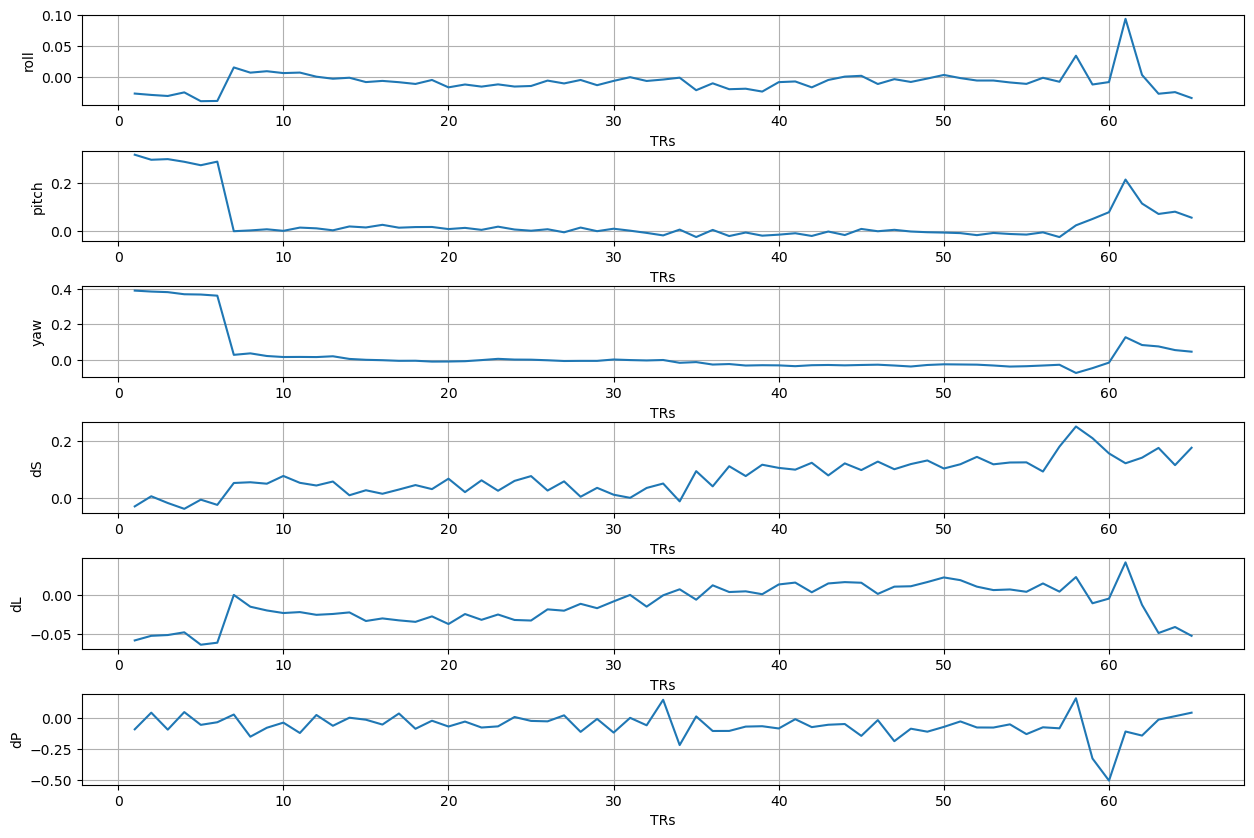

/var/folders/f3/9xmtfcls0b19f4b8lh3sws280000gn/T/ipykernel_6933/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


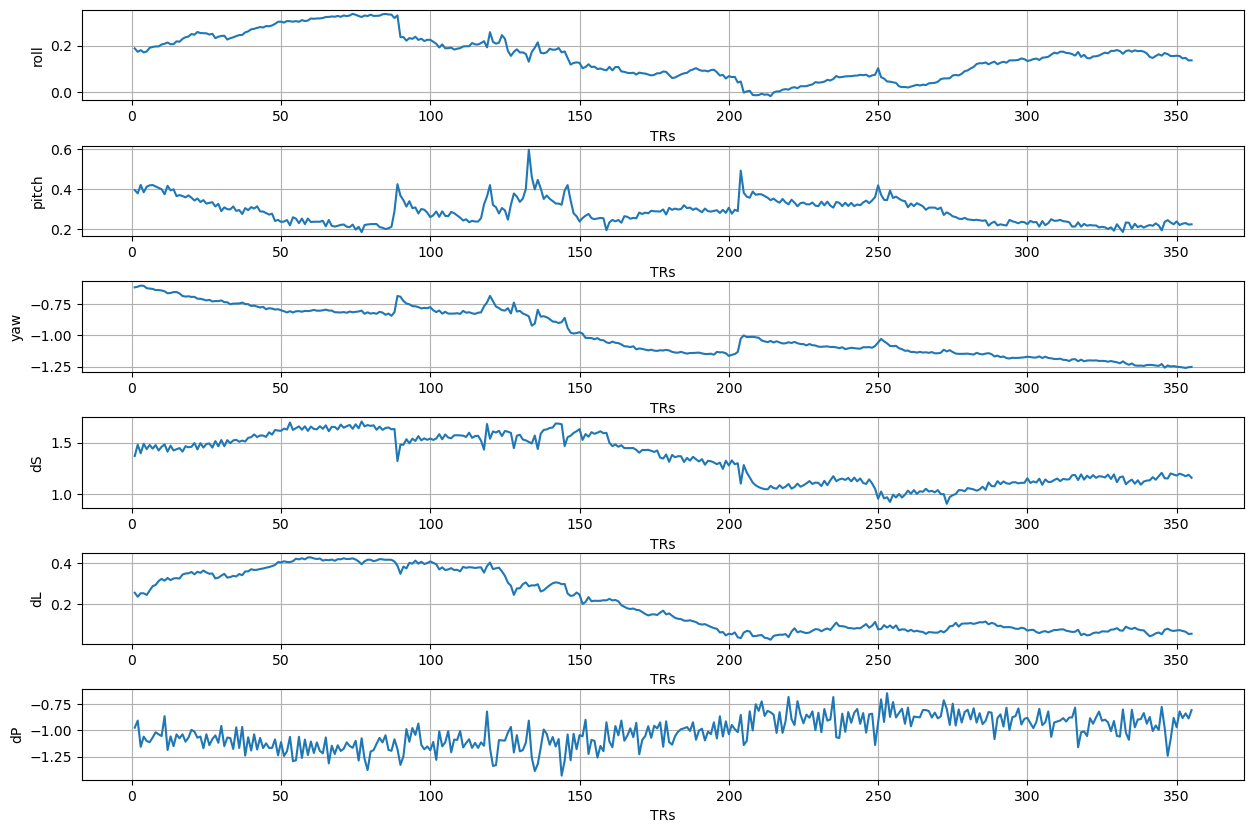

/var/folders/f3/9xmtfcls0b19f4b8lh3sws280000gn/T/ipykernel_6933/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


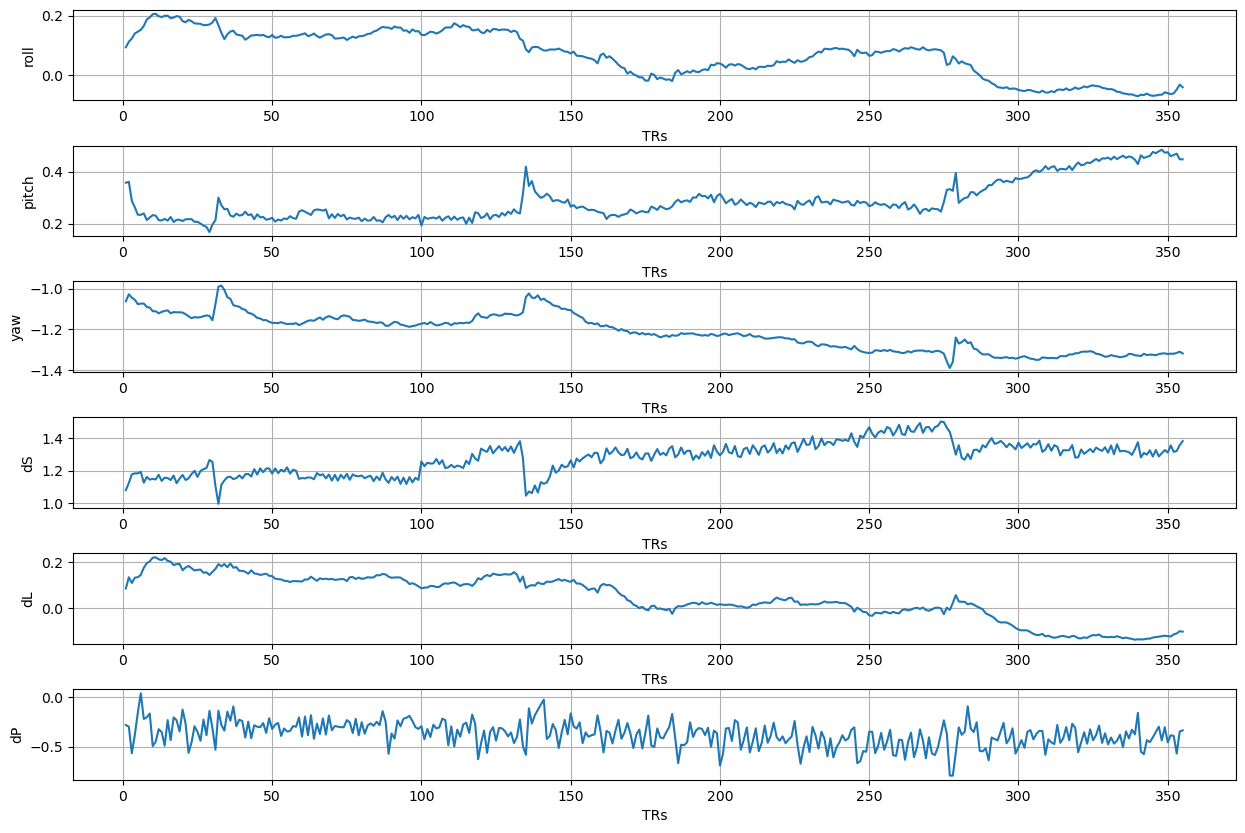

/var/folders/f3/9xmtfcls0b19f4b8lh3sws280000gn/T/ipykernel_6933/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


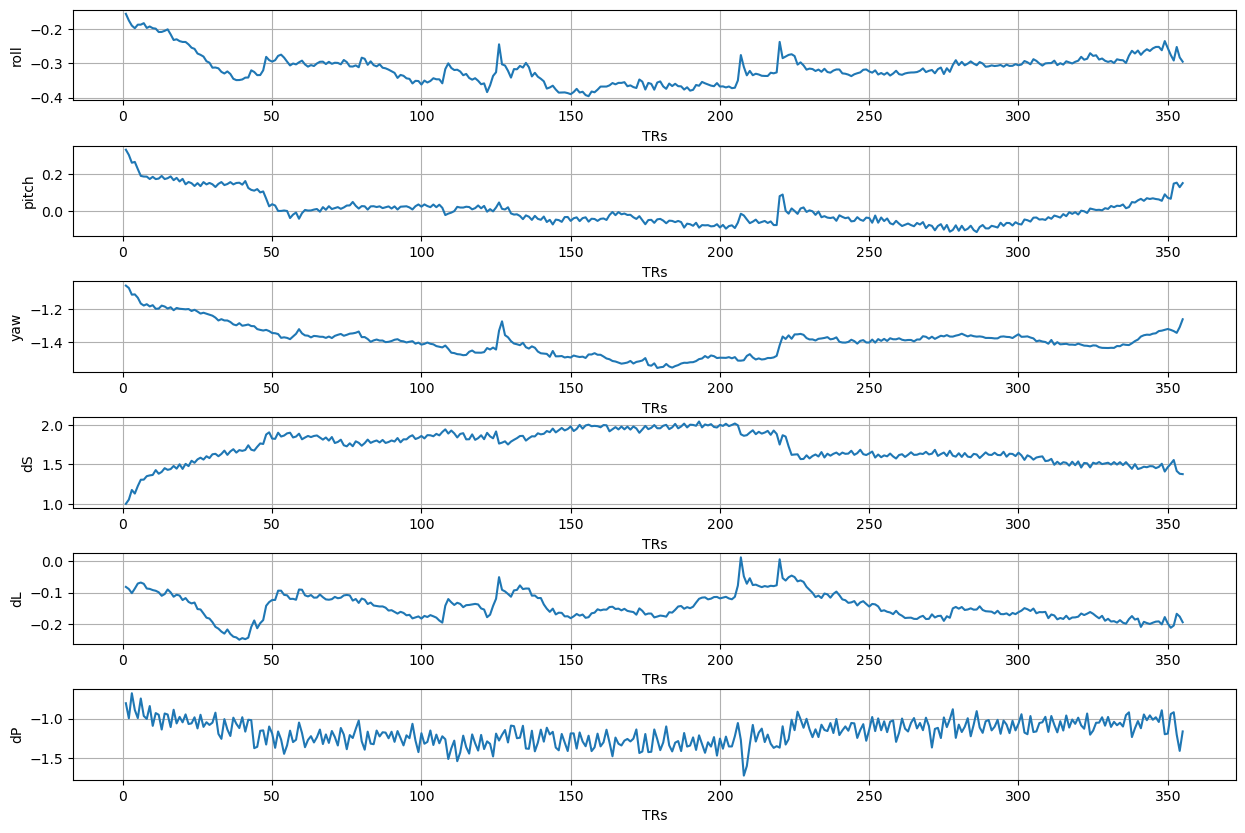

/var/folders/f3/9xmtfcls0b19f4b8lh3sws280000gn/T/ipykernel_6933/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


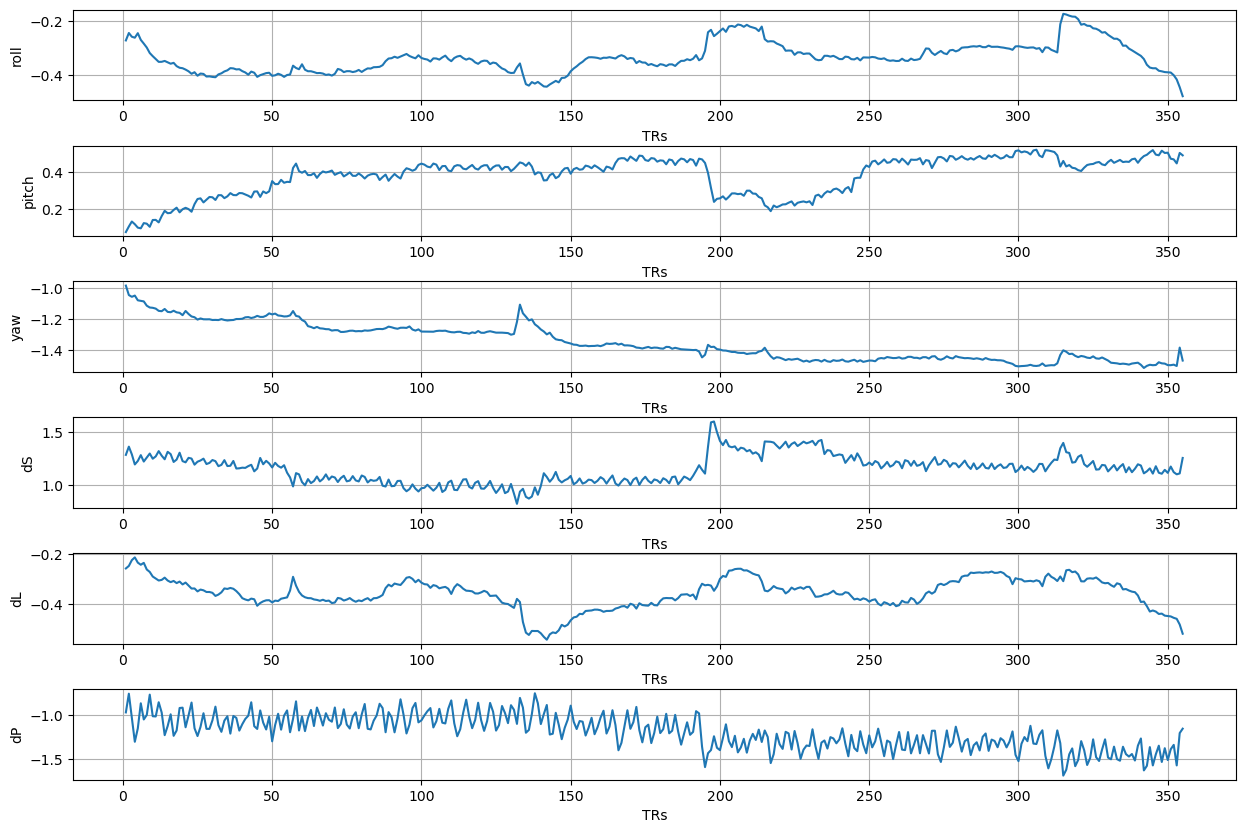

In [10]:
motion_dir = os.path.join(base_dir, f'derivatives/preproc/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']


    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()